* https://arxiv.org/pdf/1410.6551.pdf
* https://arxiv.org/pdf/1109.4561.pdf

In [96]:
Nx=8; Ny=10; N=Nx*Ny
p=1; q=Ny
cut_off=Nx
PN=[0,1,2,3]
U=2;

In [97]:
reverse(square_lattice(Nx,Ny)[1], dims=1)

10×8 OffsetArray(::Matrix{Int64}, 0:9, 0:7) with eltype Int64 with indices 0:9×0:7:
 73  74  75  76  77  78  79  80
 65  66  67  68  69  70  71  72
 57  58  59  60  61  62  63  64
 49  50  51  52  53  54  55  56
 41  42  43  44  45  46  47  48
 33  34  35  36  37  38  39  40
 25  26  27  28  29  30  31  32
 17  18  19  20  21  22  23  24
  9  10  11  12  13  14  15  16
  1   2   3   4   5   6   7   8

In [91]:
imp_site_1 = 44
imp_site_2 = 62
imp_site_3 = 1
V_1 = 5
V_2 = 5
V_3 = 0;

In [92]:
pn = maximum(PN)
N_d = 2
D = Int( ( factorial(N_d + pn - 1) / ( factorial(N_d) * factorial(pn - 1) ) ) * ( (Nx - N_d) / pn)  )
if N_d == 2
    D = N_d; # two quasihole pinned
end

2

In [93]:
using NBInclude
using LinearAlgebra
@nbinclude("Hofstadter First Band Approximation.ipynb"; regex=r"#.*executeme");

In [94]:
HHH = (H+H')/2
E, U = eigen(dense(HHH).data)
E

165-element Vector{Float64}:
 -10.259863186393682
 -10.259835032296719
 -10.233082862862455
 -10.232476002853218
 -10.226925692632664
 -10.217979885844315
 -10.20527129591008
 -10.1936134242251
 -10.189879842513609
 -10.188154511074522
 -10.185407814278863
 -10.182756299068005
 -10.180695553944734
   ⋮
  -6.043758470651459
  -5.740002818783113
  -5.483147287216168
  -3.4200534947990415
  -3.4200276711118462
  -3.42001530047214
  -3.420015300472139
  -3.4199993501461576
  -3.4199775961713366
  -3.0549884483844787
  -2.7849287397945344
   0.0

# Gram-Schmidt Process

In [209]:
function gram_schmidt_process(A; normalize=false)
	# performs Gram Schmidt process on columns of matrix A
	# the columns of the returned matrix Q are the outputs of this process
	
    m = size(A, 1)
	n = size(A, 2)
    Q = zeros(m, n)
    
    for j=1:n
        v = A[1:m, j]
		x = A[1:m, j]
        for i = 1:j - 1
            u = Q[1:m, i]
            x -= dot(u, v) * u / dot(u, u)
        end
        Q[1:m, j] = normalize ? x / norm(x) : x
    end

    return Q
end
MM = [3 2; 1 2]
MMM = gram_schmidt_process(MM; normalize=false)
MMM[:,1]'*MMM[:,2]
MMM

2×2 Matrix{Float64}:
 3.0  -0.4
 1.0   1.2

In [184]:
function classical_gram_schmidt_alt(matrix)
    # orthogonalises the columns of the input matrix
    num_vectors = size(matrix)[2]
    orth_matrix = zeros(Complex{Float64},size(matrix))
    for vec_idx = 1:num_vectors
        orth_matrix[:, vec_idx] = matrix[:, vec_idx]
        sum = zeros(size(orth_matrix[:, 1]))
        for span_base_idx = 1:(vec_idx-1)
            # compute sum
            sum += dot(orth_matrix[:, span_base_idx], orth_matrix[:, vec_idx])*orth_matrix[:, span_base_idx]
        end
        orth_matrix[:, vec_idx] -= sum
        # normalise vector
        orth_matrix[:, vec_idx] = orth_matrix[:, vec_idx]/norm(orth_matrix[:, vec_idx])
    end
    return orth_matrix
end
MM = [3 2; 1 2]
MMM = classical_gram_schmidt_alt(MM)
MMM[:,1]'*MMM[:,2]

1.1102230246251565e-16 + 0.0im

In [169]:
function modified_gram_schmidt(matrix)
    # orthogonalises the columns of the input matrix
    num_vectors = size(matrix)[2]
    orth_matrix = copy(matrix)
    for vec_idx = 1:num_vectors
        orth_matrix[:, vec_idx] = orth_matrix[:, vec_idx]/norm(orth_matrix[:, vec_idx])
        for span_base_idx = (vec_idx+1):num_vectors
            # perform block step
            orth_matrix[:, span_base_idx] -= dot(orth_matrix[:, span_base_idx], orth_matrix[:, vec_idx])*orth_matrix[:, vec_idx]
        end
    end
    return orth_matrix
end
MM = [3 2; 1 2]
MMM = modified_gram_schmidt(MM)
MMM[:,1]'*MMM[:,2]

LoadError: InexactError: Int64(0.9486832980505138)

# Adiabatic 

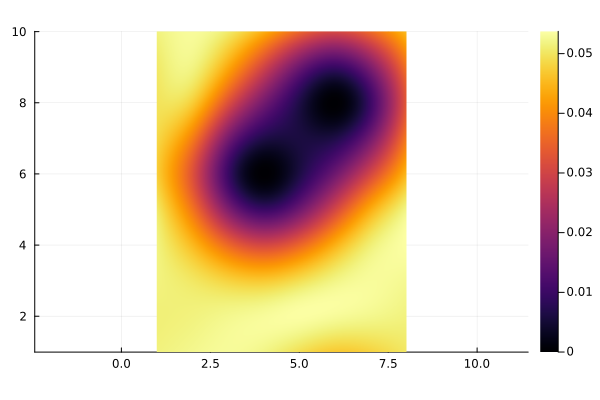

In [172]:
using Plots
using Interpolations

function Interp2D(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finery, finerx, data_interp
end

data = avg_density|>transpose
factor = 50

Plots.heatmap(Interp2D(data, factor), aspect_ratio=:equal)

In [173]:
# initial_case
H_initial, H_inital_interacting = get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
E_initial, U_inital = eigen(dense((H_initial+H_initial')/2).data);

In [202]:
# adiabatic process
mobile_imp_sites_1 = [80,8,1,73]
mobile_imp_sites_2 = [8,1,73,80,8]
adiabatic_V_imp_1 = collect(range(start = V_1, length=5, stop=0))
adiabatic_V_imp_1_reverse = reverse(adiabatic_V_imp_1)

5-element Vector{Float64}:
 0.0
 1.25
 2.5
 3.75
 5.0

In [239]:
vec_set = []
for (i, j) in zip(adiabatic_V_imp_1, adiabatic_V_imp_1_reverse)
    
    println(i,"\t",j)
    
    H, HH_Int = get_total_H(i, j, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
    E, U = eigen(dense(H).data)
    println("E and U are Calculated!")

    if lastindex(vec_set) != 1
        vec_set = push!(vec_set, U[:,1:2]) # Ground degeneracy is 2
        t = vec_set[lastindex(vec_set)-1]
        t_dt = vec_set[lastindex(vec_set)]
        println(t)
        println(t_dt)
    
        # GRAM-SCHMIDT
        matrix_1 = vcat(t,t_dt[:,1],dims=2) 
        orth_t_dt_1 = classical_gram_schmidt_alt(MM)[:,3] # her ikisine de dik bir t_dt vektörü
        matrix_2 = vcat(t,t_dt[:,2],dims=2) 
        orth_t_dt_2 = classical_gram_schmidt_alt(MM)[:,3] # her ikisine de dik diğer bir t_dt vektörü
        
        orth_vec_set = vcat(orth_t_dt_1, orth_t_dt_2, dims=2) #t_dt anında t anına dik vektörler seti
    end
end
orth_vec_set
# last(vec_set) # last of vec_set
# vec_set[lastindex(vec_set)-1] # penultimate 

5.0	0.0
E and U are Calculated!


LoadError: BoundsError: attempt to access 1-element Vector{Any} at index [0]

In [176]:
U_inital[:,1:2]

165×2 Matrix{ComplexF64}:
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
         0.0-0.0im                 0.0-0.0im
            ⋮              
   0.0151057-0.0210881im     0.0763704-0.0125482im
 -0.00490167-0.0107593im    0.00389511+0.00662504im
    0.085328+0.0678444im    -0.0261363+0.0173756im
  0.00948034-0.00247212im   -0.0212141-0.00545891im
  -0.0763227-0.163356im      0.0516362-0.11419im
   -0.012943-0.0453142im    0.00525506+0.000172767im
  0.00720174-0.017495im    -0.00161573+0.0198472im
  

In [177]:
U[:,1:2]

165×2 Matrix{ComplexF64}:
          0.0-0.0im                   0.0+0.0im
 -1.98852e-17-4.58674e-17im   2.54628e-17-2.38712e-17im
 -6.25043e-17+3.75132e-17im  -1.28995e-17+1.65906e-17im
  8.33423e-17+4.31234e-17im   6.43401e-17-7.05297e-18im
  1.19885e-17-1.12007e-16im   1.00199e-16+1.18199e-17im
  4.68802e-17-9.58785e-17im  -1.14986e-16+7.69779e-17im
 -2.92618e-17+3.91832e-17im  -6.05123e-18+3.0117e-17im
 -4.69781e-17-2.49568e-16im   8.00543e-17-1.16463e-16im
  5.59037e-17-5.59421e-17im   5.78118e-17+1.49281e-17im
  2.20015e-16+1.61965e-16im   7.64459e-18-1.40622e-17im
 -4.34551e-17-1.66896e-16im  -8.16091e-17-1.82142e-18im
  -4.0156e-16-8.69492e-17im  -2.71604e-17-6.72243e-18im
 -4.80068e-16-4.91549e-16im  -2.04221e-16-9.4979e-18im
             ⋮               
   0.00372279-0.00247869im     -0.0199419+0.0473162im
   -0.0132223-0.0209198im     -0.00518291-0.00169408im
    0.0160515+0.00117888im    -0.00633391-0.00887983im
  -0.00204519+0.0097792im       0.0436183+0.0320405im
   -0.03

In [178]:
U_inital[:,1]'*U[:,2]

-0.06112919523116542 + 0.05338208294863783im

In [182]:
vec_set = cat(U_inital[:,1:2], U[:,1:2], dims=2)

165×4 Matrix{ComplexF64}:
         0.0-0.0im         …           0.0+0.0im
         0.0-0.0im             2.54628e-17-2.38712e-17im
         0.0-0.0im            -1.28995e-17+1.65906e-17im
         0.0-0.0im             6.43401e-17-7.05297e-18im
         0.0-0.0im             1.00199e-16+1.18199e-17im
         0.0-0.0im         …  -1.14986e-16+7.69779e-17im
         0.0-0.0im            -6.05123e-18+3.0117e-17im
         0.0-0.0im             8.00543e-17-1.16463e-16im
         0.0-0.0im             5.78118e-17+1.49281e-17im
         0.0-0.0im             7.64459e-18-1.40622e-17im
         0.0-0.0im         …  -8.16091e-17-1.82142e-18im
         0.0-0.0im            -2.71604e-17-6.72243e-18im
         0.0-0.0im            -2.04221e-16-9.4979e-18im
            ⋮              ⋱  
   0.0151057-0.0210881im        -0.0199419+0.0473162im
 -0.00490167-0.0107593im       -0.00518291-0.00169408im
    0.085328+0.0678444im   …   -0.00633391-0.00887983im
  0.00948034-0.00247212im        0.0436183+0.

In [186]:
ort_vec_set = classical_gram_schmidt_alt(vec_set)

165×4 Matrix{ComplexF64}:
         0.0-0.0im         …           0.0+0.0im
         0.0-0.0im             2.82001e-17-2.69323e-17im
         0.0-0.0im            -1.32778e-17+2.16486e-17im
         0.0-0.0im             7.66009e-17-1.17784e-17im
         0.0-0.0im             1.13068e-16+1.40945e-17im
         0.0-0.0im         …  -1.38853e-16+8.90432e-17im
         0.0-0.0im            -5.39032e-18+3.62077e-17im
         0.0-0.0im             8.44692e-17-1.33181e-16im
         0.0-0.0im             6.52678e-17+1.56824e-17im
         0.0-0.0im             1.38823e-17-2.6051e-17im
         0.0-0.0im         …  -1.01909e-16+5.95945e-19im
         0.0-0.0im            -3.27172e-17+8.26401e-18im
         0.0-0.0im            -2.55572e-16+1.05891e-17im
            ⋮              ⋱  
   0.0151057-0.0210881im         0.0210551+0.0375611im
 -0.00490167-0.0107593im       -0.00460685+0.00163592im
    0.085328+0.0678444im   …    -0.0120553+0.00335973im
  0.00948034-0.00247212im        0.0388555+0

In [189]:
ort_vec_set[:,1]'*ort_vec_set[:,4]

4.163336342344337e-17 - 1.0408340855860843e-17im

In [218]:
W = Vector{Matrix{Complex{Float64}}}()
W = []
AA = push!(W, U_inital[:,1:2])
last(AA[1])

0.005389396735869762 - 0.0im

In [ ]:
path_states = []
for imp_site_2 in mobile_imp_sites
    H = get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
    E, UU = eigen(dense((H+H')/2).data)
    push!(path_states, UU)
end

In [ ]:
# Gaining phase factor through the path
path_states[1] == path_states[length(mobile_imp_sites)]

In [44]:
psi_0 = path_states[1]
psi_2pi = path_states[length(mobile_imp_sites)]
B = zeros(Complex{Float64}, size(H)[1], size(H)[2])
for i in 1:size(H)[1]
    for j in 1:size(H)[2]
        B_ij = psi_2pi[:,j]'*psi_0[:,i]
        B[i,j] = B_ij
    end
end
B_E, B_U = eigen(B)

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
165-element Vector{ComplexF64}:
 -0.9998988915483269 + 0.014219939536697802im
 -0.9998564432316362 - 0.01694381681311317im
 -0.9996416419933147 + 0.026769153757799334im
 -0.9992930991605464 + 0.03759390868371246im
 -0.9962018384910186 - 0.08707408906835117im
 -0.9930915472466821 + 0.11734214412220785im
 -0.9926511086094018 - 0.12101147291281818im
 -0.9890870103292095 + 0.1473325693729363im
  -0.983107194451102 - 0.18303071933009463im
 -0.9783755858733468 + 0.20683619839619044im
 -0.9776428873111878 + 0.2102721686049774im
 -0.9769735435963287 - 0.21336048160995255im
 -0.9669062869189581 - 0.2551317940136167im
                     ⋮
  0.9814126651002322 - 0.1919093035286761im
  0.9856273728566584 - 0.16893395714204337im
  0.9862308711420685 + 0.16537432934512164im
  0.9909587842083434 + 0.13416664265127926im
  0.9918495310755842 - 0.12741470756996873im
  0.9961969380052079 + 0.08713013662924528im
  0.9970589363